In [1]:
!python3 --version

Python 3.9.18


In [2]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping: no known devices.


In [5]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [6]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import tifffile as tiff

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [7]:
from custom import CustomConfig, CustomDataset


In [14]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
LOG_PATH = '/Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/logs'
WEIGHTS_SUBPATH = 'multicell20240319T2245/mask_rcnn_multicell_0050.h5'
#WEIGHTS_SUBPATH = 'cell20240404T1736/mask_rcnn_cell_0050.h5'
model_path = os.path.join(LOG_PATH, WEIGHTS_SUBPATH)

# Load trained weights
print("Loading weights from ", model_path)
#model.load_weights(model_path, by_name=True)
tf.keras.Model.load_weights(model.keras_model, model_path , by_name=True, skip_mismatch=True)

RESULTS_DIR = os.path.join(ROOT_DIR, "results", WEIGHTS_SUBPATH[:-3])
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

Loading weights from  /Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/logs/multicell20240319T2245/mask_rcnn_multicell_0050.h5


2024-04-08 15:17:55.924273: W tensorflow/c/c_api.cc:305] Operation '{name:'res4b_branch2c_2/kernel/Assign' id:19707 op device:{requested: '', assigned: ''} def:{{{node res4b_branch2c_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](res4b_branch2c_2/kernel, res4b_branch2c_2/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [16]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("/Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/data", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("/Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/data", "valid")
dataset_val.prepare()

/Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/data/valid/imgs/281.it11.20x.r2.5.tif
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2752.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:   12.00000  max:  703.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


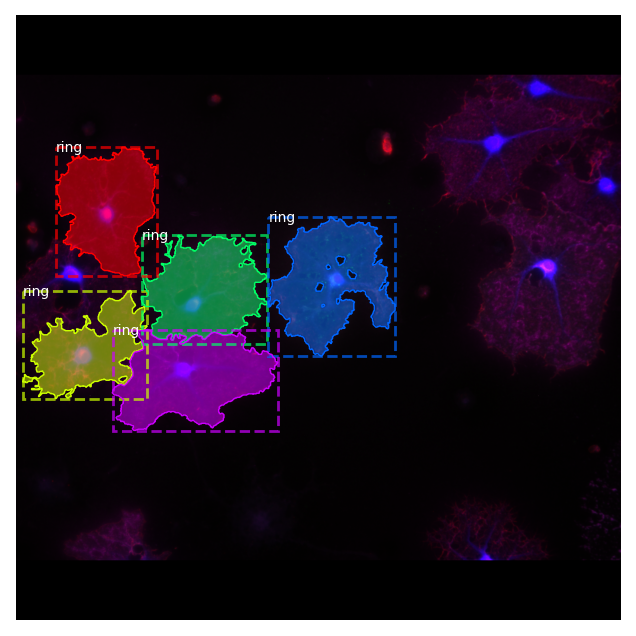

In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print(dataset_val.image_info[image_id]['path'])

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

281.it12.20x.r1.3.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2024-04-08 15:18:49.270876: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_detection_2/Reshape_1' id:25023 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection_2/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection_2/packed, mrcnn_detection_2/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
W0000 00:00:1712614729.809260       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } input

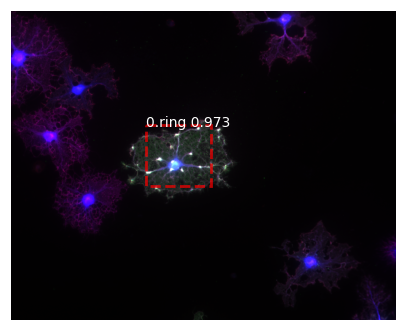

281.it10.20x.r3.8.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


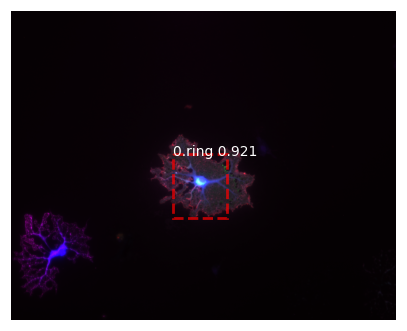

281.it10.20x.r1.9.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


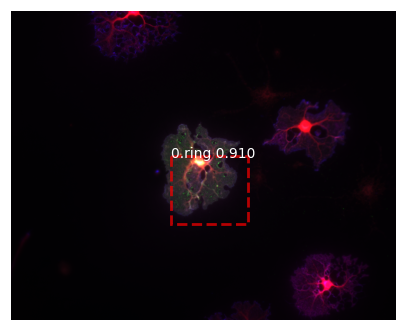

281.it10.20x.r1.8.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


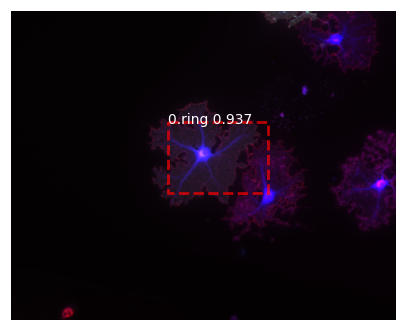

image_06.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


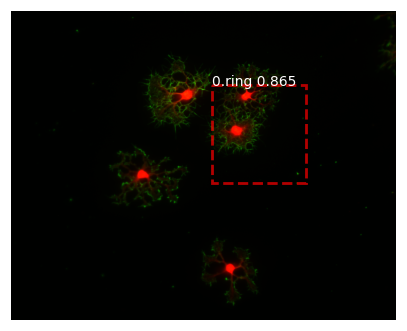

281.it11.20x.r1.10.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


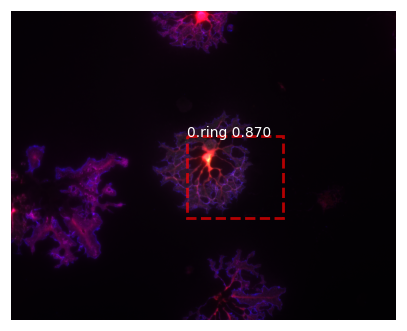

281.it11.20x.r2.2.weirdmbp.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


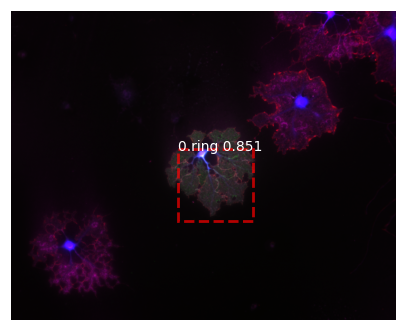

281.it10.20x.r2.4.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


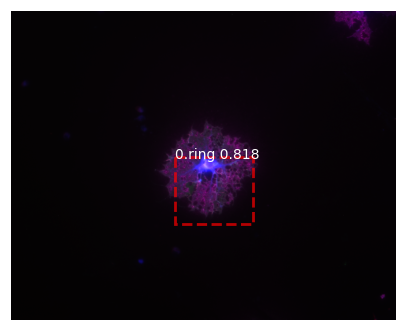

281.it11.20x.r2.3.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


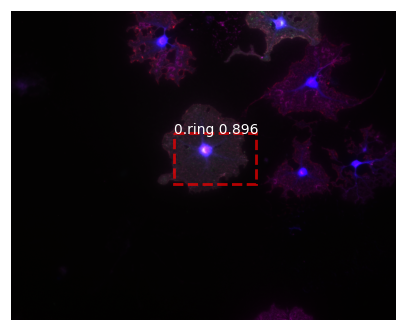

281.it11.20x.r2.1.weirdmbp.tif
Processing 1 images
image                    shape: (2208, 2752, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2752.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


KeyboardInterrupt: 

In [18]:

import skimage
real_test_dir = '/Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/data/test/imgs'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg','.tif']:
        image_paths.append(os.path.join(real_test_dir, filename))

res_list = [] 
for image_path in image_paths:
    image_name = os.path.basename(image_path)
    print(image_name)
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    #extract objects individually and add to df
    for i in range(r['masks'].shape[2]):
        mask = (r['masks'][:,:,i]*255).astype(np.uint8)
        tiff.imwrite(os.path.join(RESULTS_DIR, image_name[:-4] + '_mask_' + str(i) + '.tif'),mask)
        res_list.append([image_name, i, dataset_val.class_names[r['class_ids'][i]], r['scores'][i], r['rois'][i]])

res_df = pd.DataFrame(res_list, columns=['image_name', 'detection_id', 'class', 'score', 'bbox [y1, x1, y2, x2]'])
res_df.to_csv(os.path.join(RESULTS_DIR, 'detection_results.csv'), index=False)    
    

In [ ]:
#!pip install numpy==1.20.3
#!pip install seaborn
#!pip install sklearn
#!pip install scikit-learn

# Confusion Matrix on Validation Dataset


In [ ]:
# old numpy version was  1.19.5.


config=inference_config
dataset = dataset_val


gt_tot = np.array([])
pred_tot = np.array([])

#mAP list
mAP_ = []

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])

    #print("Predicted object : "+dataset.class_names[pred])
    # for j in range(len(dataset.class_names[gt])):
	    # print("Ground truth object : "+j)
import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1
the actual len of the pred vect is :  1
Average precision of this image :  1.0
The actual mean average precision for the whole images 1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt

KeyboardInterrupt: 

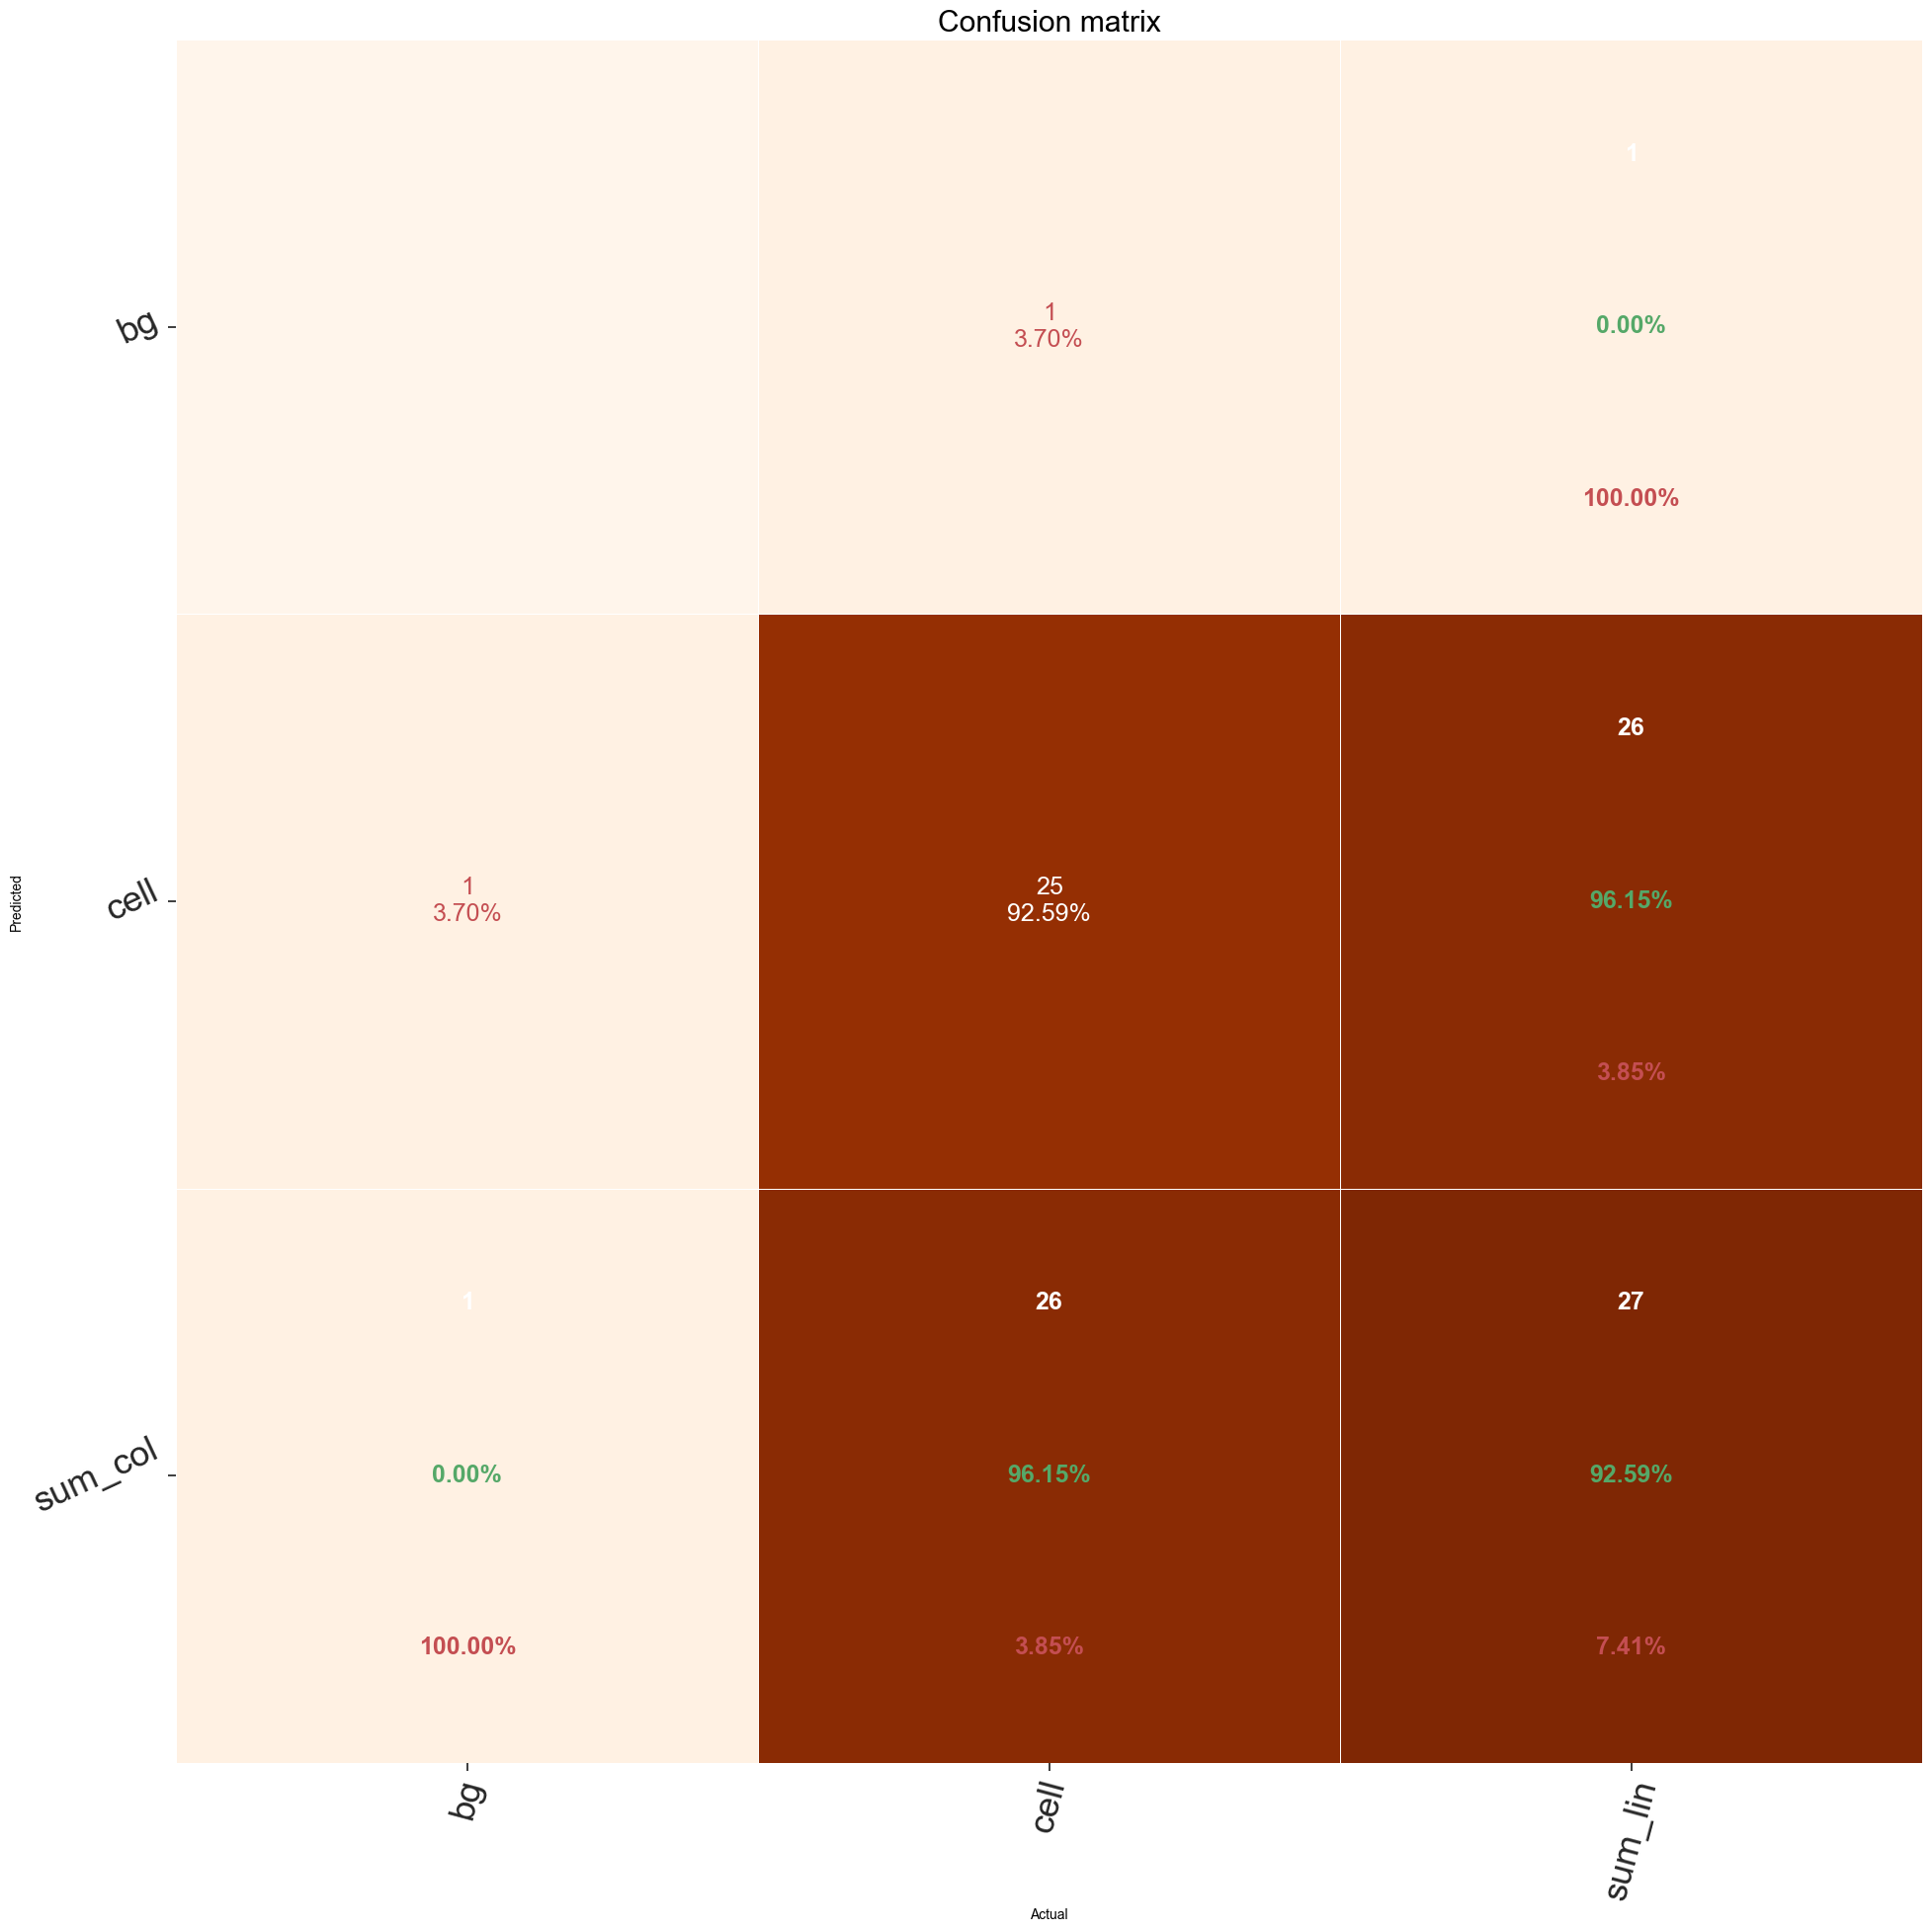

In [ ]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","cell"] ,fz=18, figsize=(20,20), lw=0.5)

In [ ]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 25]
fp for each class : [1, 1]
fn for each class : [1, 1]

########################

tp for each class : [25]
fp for each class : [1]
fn for each class : [1]


# # Draw precision-recall curve  

##### The PR curve is for single detected image 

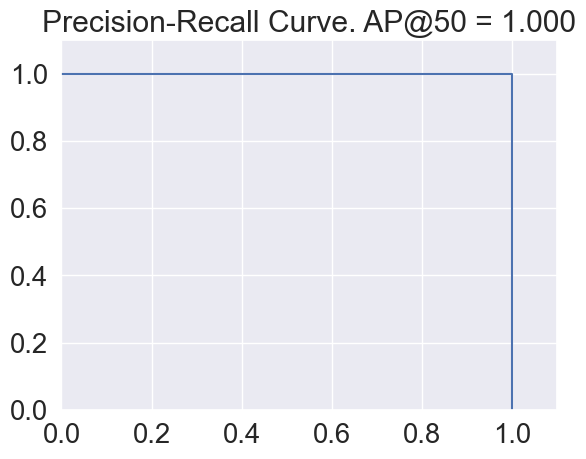

In [ ]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# calculate the mAP for a batch of validation images

Re-starting from epoch 50
Images: 26
Classes: ['BG', 'ring']
Loading weights  /Users/tom/Desktop/Stanford/RA/OligodendroSight/mrcnn/logs/cell20240222T0027/mask_rcnn_cell_0050.h5


2024-03-11 09:28:10.866596: W tensorflow/c/c_api.cc:305] Operation '{name:'res3b_branch2c_1/kernel/Assign' id:10939 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node res3b_branch2c_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](res3b_branch2c_1/kernel, res3b_branch2c_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
W0000 00:00:1710174492.457769       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size

mAP @ IoU=50:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


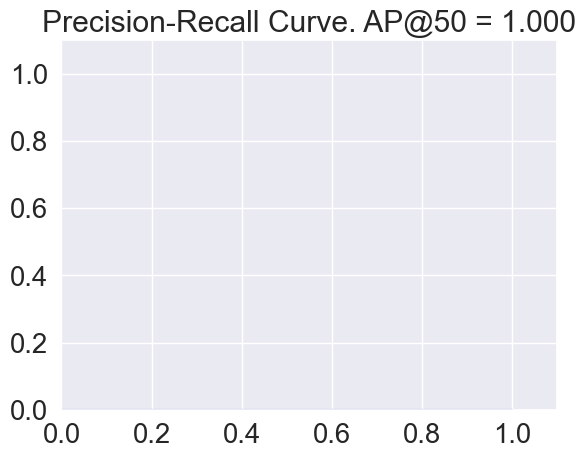

In [ ]:
path = os.getcwd()
#model_tar = "nuclei_datasets.tar.gz"
data_path = os.path.join(path + '/data')
model_path = os.path.join(path + '/logs/cell20240222T0027')
weights_path = os.path.join(model_path + '/mask_rcnn_cell_0050.h5') #My weights file

DEVICE = "/cpu:0" 


config=inference_config
dataset = dataset_val


with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config)

model.load_weights(weights_path, by_name=True)

    
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls

#dataset.load_nucleus(data_path, 'val')
#dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Loading weights ", weights_path)

image_ids = np.random.choice(dataset.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()
    
    
    

# Load a random image from the images folder and perform prediction

In [ ]:

# IMAGE_DIR = os.path.join(ROOT_DIR, "test_images")

# # COCO Class names
# # Index of the class in the list is its ID. For example, to get ID of
# # the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'Hard_hat', 'Safety_vest']

# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])